In [4]:
from myFunctions import *


Experiment Bollinger Bands on single time series

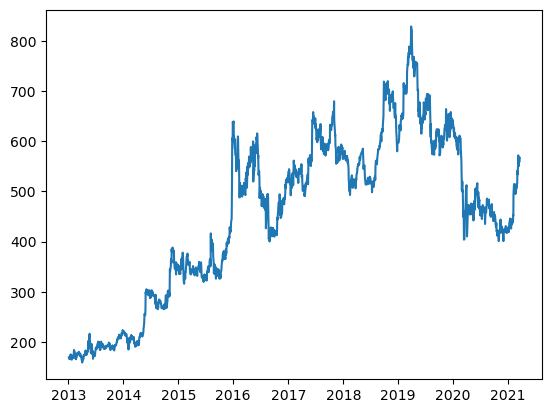

In [5]:
JT1332 = df['1332 JT']
JT1332.tail(10)
plt.plot(JT1332['last'])

Bollinger Bands

In [6]:
bollinger = JT1332.copy()
bollinger['ma20'] = bollinger['last'].rolling(window=20).mean()
bollinger['std'] = bollinger['last'].rolling(window=20).std()
bollinger['upper_band'] = bollinger['ma20'] + (2 * bollinger['std'])
bollinger['lower_band'] = bollinger['ma20'] - (2 * bollinger['std'])
bollinger['return'] = np.log(bollinger['last']/bollinger['last'].shift(1))

In [7]:
# buy signal
bollinger['signal'] = np.where((bollinger['last'] < bollinger['lower_band']) &
                        (bollinger['last'].shift(1) >= bollinger['lower_band']),1,0)

# sell signal
bollinger['signal'] = np.where((bollinger['last'] > bollinger['upper_band']) &
                        (bollinger['last'].shift(1) <= bollinger['upper_band']),-1,bollinger['signal'])

In [8]:
bollinger['position'] = bollinger['signal'].replace(to_replace=0, method='ffill')
bollinger['position'] = bollinger['position'].shift(1)
bollinger['bollinger_returns'] = bollinger['return'] * (bollinger['position'])

In [9]:
bollinger.tail(10)

,last,volume,ma20,std,upper_band,lower_band,return,signal,position,bollinger_returns
date,,,,,,,,,,
2021-03-08,552.0,2462700,514.55,16.103203,546.756407,482.343593,0.018282,-1,-1.0,-0.018282
2021-03-09,572.0,2801300,518.50,19.802977,558.105954,478.894046,0.035591,-1,-1.0,-0.035591
2021-03-10,550.0,3499400,520.40,20.936998,562.273996,478.526004,-0.039221,0,-1.0,0.039221
2021-03-11,556.0,1810800,522.70,22.221611,567.143222,478.256778,0.010850,0,-1.0,-0.010850
2021-03-12,557.0,2230300,524.80,23.408500,571.617001,477.982999,0.001797,0,-1.0,-0.001797
2021-03-15,560.0,1537500,527.50,24.225910,575.951821,479.048179,0.005372,0,-1.0,-0.005372
2021-03-16,559.0,1594200,529.95,24.833074,579.616149,480.283851,-0.001787,0,-1.0,0.001787
2021-03-17,561.0,1328200,532.75,25.028142,582.806284,482.693716,0.003571,0,-1.0,-0.003571
2021-03-18,565.0,1421200,535.70,25.185836,586.071671,485.328329,0.007105,0,-1.0,-0.007105


In [10]:
print("Buy and hold returns:",bollinger['return'].cumsum().iloc[-1])
print("Strategy returns:",bollinger['bollinger_returns'].cumsum().iloc[-1])
bollinger[['bnh_cumsum','bollinger_cumsum']] = bollinger[['return','bollinger_returns']].cumsum()

Buy and hold returns: 1.2098767356114886
Strategy returns: -0.3906259508042675


Visualisation of Buy & Hold and Bollinger Bands Strategy on ticker '1332 JT'

<Axes: xlabel='date'>

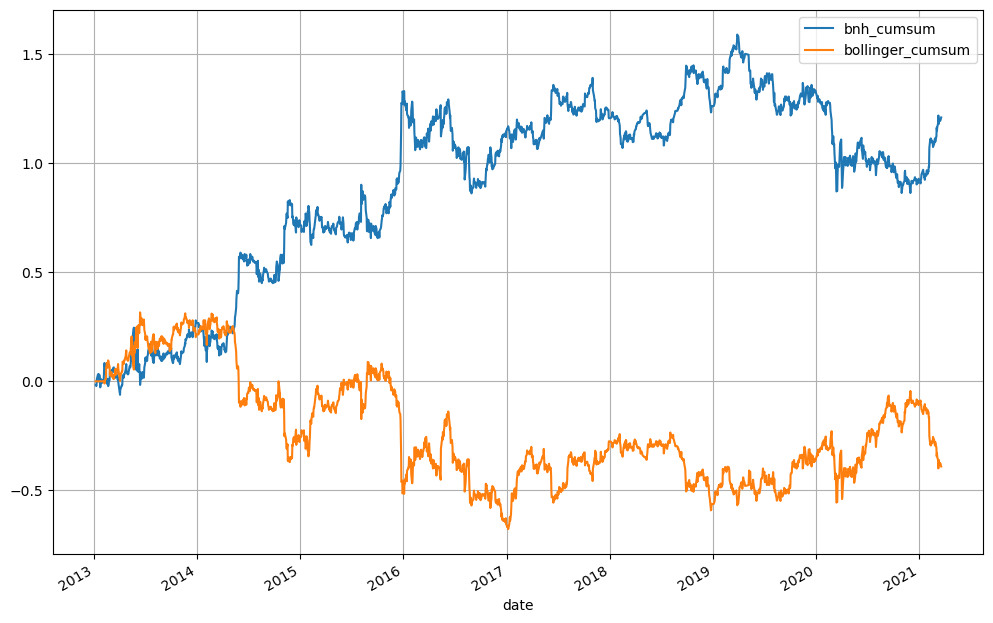

In [11]:
# plotting historical performance
bollinger[['bnh_cumsum','bollinger_cumsum']].plot(grid=True, figsize=(12, 8))

Implement bollinger bands on all 248 time series

In [12]:
def bollinger_bands(df):

    res = {}

    for k,v in df.items():
        bollinger = v.copy()
        bollinger['ma20'] = bollinger['last'].rolling(window=20).mean()
        bollinger['std'] = bollinger['last'].rolling(window=20).std()
        bollinger['upper_band'] = bollinger['ma20'] + (2 * bollinger['std'])
        bollinger['lower_band'] = bollinger['ma20'] - (2 * bollinger['std'])
        bollinger['return'] = np.log(bollinger['last']/bollinger['last'].shift(1))

        # buy signal
        bollinger['signal'] = np.where((bollinger['last'] < bollinger['lower_band']) &
                                (bollinger['last'].shift(1) >= bollinger['lower_band']),1,0)

        # sell signal
        bollinger['signal'] = np.where((bollinger['last'] > bollinger['upper_band']) &
                                (bollinger['last'].shift(1) <= bollinger['upper_band']),-1,bollinger['signal'])
        
        bollinger['position'] = bollinger['signal'].replace(to_replace=0, method='ffill')
        bollinger['position'] = bollinger['position'].shift(1)
        bollinger['bollinger_returns'] = bollinger['return'] * (bollinger['position'])

        avg_return = np.mean(bollinger['bollinger_returns'])
        std_return = np.std(bollinger['bollinger_returns'])
        sharpe_ratio = (avg_return - rfr) / std_return

        sortino_ratio = calculate_sortino_ratio(bollinger['bollinger_returns'], rfr)
        
        max_drawdown = calculate_max_drawdown(bollinger['bollinger_returns'])

        skewness = bollinger['bollinger_returns'].skew()
        kurt = bollinger['bollinger_returns'].kurtosis()

        res[k] = {
            'Cumulative Returns': bollinger['bollinger_returns'].cumsum().iloc[-1],
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Sortino_Ratio': sortino_ratio,
            'Skewness': skewness,
            'Kurtosis': kurt
        }
        
    return res

In [13]:
def buyAndHold(df):
    res = {}

    for k,v in df.items():
        bollinger = v.copy()
        bollinger['ma20'] = bollinger['last'].rolling(window=20).mean()
        bollinger['std'] = bollinger['last'].rolling(window=20).std()
        bollinger['upper_band'] = bollinger['ma20'] + (2 * bollinger['std'])
        bollinger['lower_band'] = bollinger['ma20'] - (2 * bollinger['std'])
        bollinger['return'] = np.log(bollinger['last']/bollinger['last'].shift(1))

        avg_return = np.mean(bollinger['return'])
        std_return = np.std(bollinger['return'])
        sharpe_ratio = (avg_return - rfr) / std_return

        sortino_ratio = calculate_sortino_ratio(bollinger['return'], rfr)
        
        max_drawdown = calculate_max_drawdown(bollinger['return'])

        skewness = bollinger['return'].skew()
        kurt = bollinger['return'].kurtosis()

        res[k] = {
            'Cumulative Returns': bollinger['return'].cumsum().iloc[-1],
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Sortino_Ratio': sortino_ratio,
            'Skewness': skewness,
            'Kurtosis': kurt
        }
        
    return res

In [14]:
blg_df = bollinger_bands(df)
bah_df = buyAndHold(df)

Averaged performance of Buy and Hold Strategy

In [15]:
metrics_df = pd.DataFrame.from_dict(bah_df, orient = "index")
avg_df = metrics_df.mean()
avg_df

Cumulative Returns    0.710773
Sharpe_Ratio         -0.968030
Max_Drawdown         -0.588662
Sortino_Ratio        -1.161210
Skewness              0.056007
Kurtosis              5.167570
dtype: float64

Averaged Performance of Bollinger Bands Strategy

In [16]:
metrics_df = pd.DataFrame.from_dict(blg_df, orient = "index")
avg_df = metrics_df.mean()
avg_df

Cumulative Returns   -0.020944
Sharpe_Ratio         -1.002862
Max_Drawdown         -0.628973
Sortino_Ratio        -1.191371
Skewness             -0.065120
Kurtosis              5.291701
dtype: float64